# Energy Efficiency Prediction

This notebook trains regression models to predict the heating load of buildings from the [UCI Energy Efficiency dataset](https://archive.ics.uci.edu/dataset/242/energy+efficiency).

## Dataset Overview

The dataset contains simulated building characteristics (surface area, glazing, orientation, etc.) and their heating and cooling loads. We focus on *heating load* (`heating_load`) as the target variable, using the remaining features as predictors.

In [1]:
!pip install -q pandas numpy scikit-learn seaborn matplotlib openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8')
sns.set_context('talk')

DATA_PATH = Path('ENB2012_data.xlsx')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH.resolve()}. Download it before running the notebook.")

In [3]:
raw_df = pd.read_excel(DATA_PATH)
raw_df = raw_df.rename(columns={
    'X1': 'relative_compactness',
    'X2': 'surface_area',
    'X3': 'wall_area',
    'X4': 'roof_area',
    'X5': 'overall_height',
    'X6': 'orientation',
    'X7': 'glazing_area',
    'X8': 'glazing_area_distribution',
    'Y1': 'heating_load',
    'Y2': 'cooling_load'
})
raw_df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
relative_compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
surface_area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
wall_area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
roof_area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
overall_height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
glazing_area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
glazing_area_distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
heating_load,768.0,22.307195,10.090204,6.01,12.9925,18.95,31.6675,43.10
cooling_load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


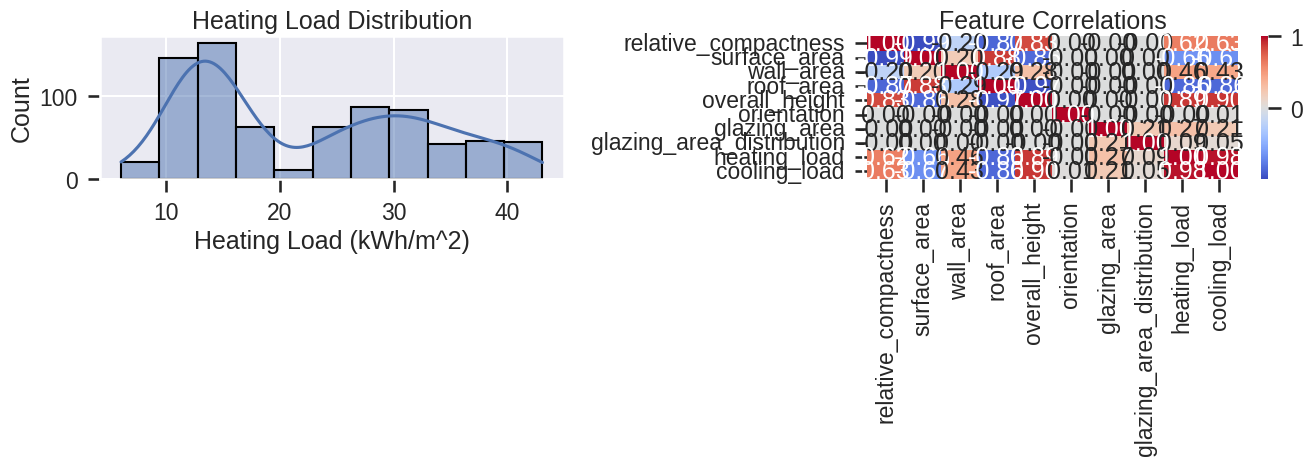

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(raw_df['heating_load'], kde=True, ax=axes[0])
axes[0].set_title('Heating Load Distribution')
axes[0].set_xlabel('Heating Load (kWh/m^2)')

correlation = raw_df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Feature Correlations')

plt.tight_layout()

## Train-Test Split

We hold out 20% of the data as a test set to estimate generalisation performance.

In [6]:
target = 'heating_load'
feature_cols = [col for col in raw_df.columns if col not in {target, 'cooling_load'}]
X = raw_df[feature_cols]
y = raw_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((614, 8), (154, 8))

## Model Training

We compare two regressors within the same preprocessing pipeline: a linear regression baseline and a random forest regressor.

Scaling the numeric features ensures that models sensitive to feature scales perform reliably.

In [7]:
numeric_features = feature_cols
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)]
)

linear_pipeline = Pipeline(
    steps=[('preprocess', preprocessor), ('model', LinearRegression())]
)

forest_pipeline = Pipeline(
    steps=[('preprocess', preprocessor), ('model', RandomForestRegressor(
        n_estimators=500, random_state=42
    ))]
)

linear_pipeline.fit(X_train, y_train)
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['relative_compactness',
                                                   'surface_area', 'wall_area',
                                                   'roof_area',
                                                   'overall_height',
                                                   'orientation',
                                                   'glazing_area',
                                                   'glazing_area_distribution'])])),
                ('model',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

In [9]:
def evaluate(model, X_train, X_test, y_train, y_test):
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    metrics = {
        'rmse_train': mean_squared_error(y_train, preds_train)**0.5,
        'rmse_test': mean_squared_error(y_test, preds_test)**0.5,
        'r2_train': r2_score(y_train, preds_train),
        'r2_test': r2_score(y_test, preds_test)
    }
    return metrics

results = pd.DataFrame({
    'LinearRegression': evaluate(linear_pipeline, X_train, X_test, y_train, y_test),
    'RandomForest': evaluate(forest_pipeline, X_train, X_test, y_train, y_test)
}).T
results

,rmse_train,rmse_test,r2_train,r2_test
LinearRegression,2.893119,3.025427,0.917065,0.912185
RandomForest,0.174362,0.492361,0.999699,0.997674


/tmp/ipython-input-595182956.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


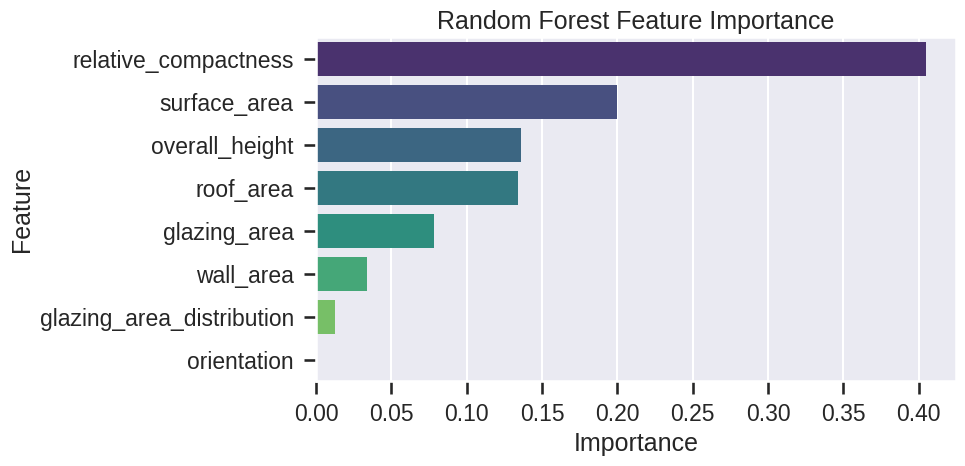

In [10]:
importances = forest_pipeline.named_steps['model'].feature_importances_
feature_importance = pd.Series(importances, index=numeric_features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

## Next Steps

- Try hyperparameter tuning (e.g., `RandomizedSearchCV`) to further improve the ensemble.
- Explore predicting `cooling_load` or multi-output models for joint heating/cooling predictions.
- Incorporate cross-validation and additional diagnostics (residual plots, SHAP explanations) for deeper insight.